In [341]:
from __future__ import print_function
from dolfin import *
import numpy as np


#dubtes i coses a revisar:
# a l'hora de normalitzar, cal normalitzar gradB? o fent f/f0 ja queda normalitzat??
# revisar tmb el grau de grad B, cal normalitzar amb br tmb??
# fer mesh no uniforme

In [342]:
# Variables: 

mu = Constant(0.000852)       #viscositat
rho = Constant(1)             #densitat (kg/m3)

c0 = Constant(0.1)            #concentració incial (kg/m3)
Ms = Constant(42.7)           #magnetització de saturació (Am2/kg)
dyBmax = Constant(95.74)      #valor absolut màxim del gradient de B (T/m)

hi = 0.015                    #alçada de l'imant (m)
r = 0.007                     #radi de l'imant (m)
Br = 1.45                     #flux magnetic romanent (T)

#Normalització
l0 = Constant(0.01)           #longitud característica (m)
b = Constant(1)               #base de la cubeta/l0
h = Constant(3)               #altura de la cubeta/l0
f0 = c0*Ms*dyBmax             #força màxima?          
p0 = f0*l0                    #pressió característica
u0 = sqrt(f0*l0/rho)          #velocitat característica
t0 = l0/u0                    #temps característica
Re = rho*l0*u0/(2*mu)         #nombre de Reynolds
print(u_0)

#constants:
mu_ = 0.000852                #viscositat
rho_ = 1                      #densitat
c_0 = 0.1                     #concentració incial
M_s = 42.7                    #magnetització de saturació
dyB_max = 95.74               #valor absolut màxim del gradient de B (T/m)
l_0 = 0.01                    #longitud característica (m)
b_ = 1                        #base de la cubeta/l0
h_ = 3                        #altura de la cubeta/l0
f_0 = c_0*M_s*dyB_max         #força màxima?          
p_0 = f_0*l_0                 #pressió característica
u_0 = sqrt(f_0*l_0/rho_)      #velocitat característica
t_0 = l_0/u_0                 #temps característica
Re_ = rho_*l_0*u_0/(2*mu_)    #nombre de Reynolds

print(p_0)


#comencem amb un temps de 15 minuts

t_0=u_0/l_0                   #temps característic
print(t_0)
T = 900                       #temps total
T_=T/t_0
dt = T / num_steps            #dt
num_steps = 1800              #nombre de time steps
dt = T / num_steps            #dt
k = Constant(dt)

print(dt)
print(Re_*2)




2.0219045476975417
4.0880980000000005
202.19045476975415
0.5
23.731274034008706


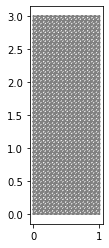

In [343]:
# Mallat uniforme
N= 15
M=3*N
mesh=RectangleMesh(Point(0, 0), Point(b, h), N, M)
plot(mesh)

# Mallat no uniforme

V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 2)       # espai per la pressió

In [344]:
# Definim les condicions de contorn


def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

base  = 'near(x[1], 0) || near(x[1], 3)' 
paret = 'near(x[0], 0) || near(x[0], 1)'

#velocitat
bcu_base  = DirichletBC(V, Constant((0, 0)), base)
bcu_paret  = DirichletBC(V, Constant((0, 0)), paret)
#pressió
patm = 101325
patm0 = patm/p_0
print(patm0)
bcp_base  = DirichletBC(Q, patm0 , base) 
bcp_paret  = DirichletBC(Q, patm0, paret) 

bcu = [bcu_base, bcu_paret] 
bcp = [bcp_base, bcp_paret]

24785.36473440705


In [345]:
# Define trial and test functions
#velocitat
u = TrialFunction(V)
v = TestFunction(V)
#pressió
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)


In [346]:
# càlcul del gradB_max

y_0=0
delta_B=((Br*r**2)/2)*((pow((y_0+hi)**2+r**2,-3/2))-(pow(y_0**2+r**2,-3/2)))
print(delta_B)

-95.73878719713858


In [347]:
# Define expressions used in variational forms

#funció gradient

#def dyB_(y):
    #return ((1.45*0.007*0.007)/2)*((pow((y+1.5)*(y+1.5)+0.007*0.007,-3/2))-(pow(y*y+0.007*0.007,-3/2)))/95.74

#dyB__= Expression(('dyB_(x[1])'), degree=2)

dyB = Expression(('((1.45*0.007*0.007)/2)*((pow((x[1]+1.5)*(x[1]+1.5)+0.007*0.007,-3/2))-(pow(x[1]*x[1]+0.007*0.007,-3/2)))/95.74'), degree=2)
M   = Constant([0,1])
c   = Constant(1)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = c*M*dyB

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return epsilon(u)/Re - p*Identity(len(u))

In [348]:
# Define variational problem for step 1
F1 = dot((u - u_n) / k, v)*dx + \
     dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx



In [349]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

In [350]:
import matplotlib.pyplot as plt
eix_x = np.linspace(0, 1, 3)
u_05=[]
u_t = []
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    
    # Guardem el mòdul de la velocitat en el punt 0.5,0.1


    for i, x in enumerate(eix_x):
        u_05.append(e0)
        u_05[i] = u_(x,0.1)

    modul = np.linalg.norm(u_05[1])
    u_t.append(modul)





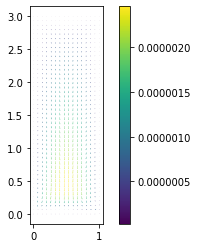

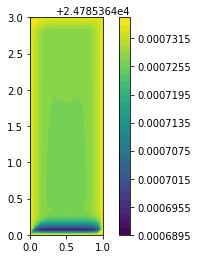

In [351]:
# Solució "normalitzada" 
plot(u_)

c=plot(u_)
plt.colorbar(c)
plt.show()

c_=plot(p_)
plt.colorbar(c_)
plt.show()

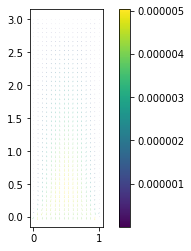

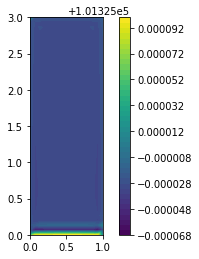

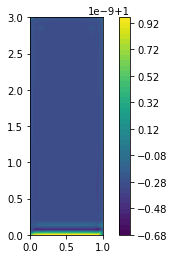

In [352]:
# Solució
u_d= u_*u_0
p_d=p_*p_0

c=plot(u_d)
plt.colorbar(c)
plt.show()

c_=plot(p_d)
plt.colorbar(c_)
plt.show()

#pressió/patm
p_datm = p_d/patm
c_=plot(p_datm)
plt.colorbar(c_)
plt.show()

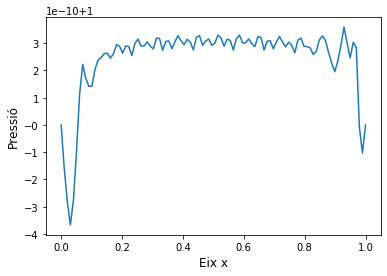

In [353]:
# Comprovem si es compleixen les condicions de contorn, comencem per la pressió
# ho farem representant-la per y=0.001m i dividint-la per la pressió atm

M=100
eix_x = np.linspace(0, 1, M)
p_y_01 = np.zeros(M)

for i, x in enumerate(eix_x):
    p_y_01[i] = p_(x,0.1)/patm0

    
plt.plot(eix_x, p_y_01)
plt.xlabel('Eix x', fontsize=12)
plt.ylabel('Pressió',fontsize=12)

plt.show()

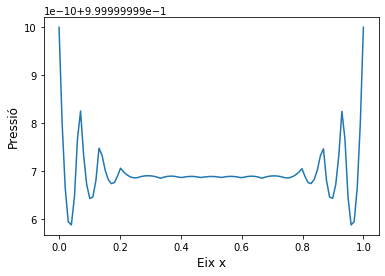

In [354]:
# provem ara amb y=1

M=100
eix_x = np.linspace(0, 1, M)
p_y_01 = np.zeros(M)

for i, x in enumerate(eix_x):
    p_y_01[i] = p_(x,1)/patm0

    
plt.plot(eix_x, p_y_01)
plt.xlabel('Eix x', fontsize=12)
plt.ylabel('Pressió',fontsize=12)

plt.show()

Text(0.5, 1.0, 'Solució per y=0.1')

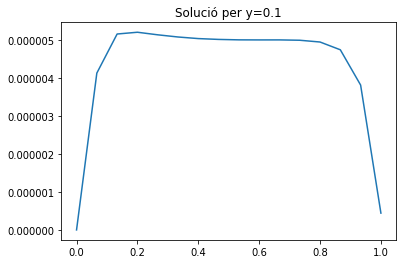

In [355]:
# fem el mateix amb la velocitat per y=0.1

eix_x = np.linspace(0, 1, N+1)
e0 = [0,0,0]
u_y_01=[]

for i, x in enumerate(eix_x):
    u_y_01.append(e0)
    u_y_01[i] = u_(x,0.1)

u_y_01_m = []
for i, x in enumerate(eix_x):
    modul = np.linalg.norm(u_y_01[i])*u_0
    u_y_01_m.append(modul)

    
plt.plot(eix_x, u_y_01_m, label= 'Solució numèrica')
plt.title("Solució per y=0.1")


Text(0.5, 1.0, 'Solució per y=1')

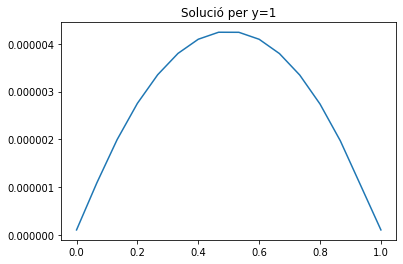

In [356]:
# fem el mateix amb la velocitat per y=1

eix_x = np.linspace(0, 1, N+1)
e0 = [0,0,0]
u_y_01=[]

for i, x in enumerate(eix_x):
    u_y_01.append(e0)
    u_y_01[i] = u_(x,1)

u_y_01_m = []
for i, x in enumerate(eix_x):
    modul = np.linalg.norm(u_y_01[i])*u_0
    u_y_01_m.append(modul)

    
plt.plot(eix_x, u_y_01_m, label= 'Solució numèrica')
plt.title("Solució per y=1")

Text(0.5, 1.0, 'Solució per y=1')

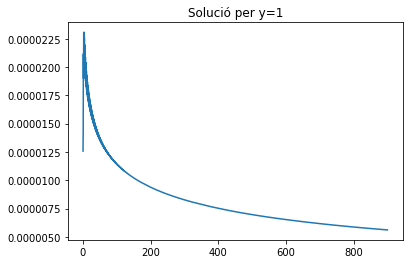

In [357]:
#Representem el modul de la velocitat en el punt (0.5,0.1) al llarg del temps

t=0
temps=[]
for i in range(num_steps):
    t += dt
    temps.append(t)
u_t=u_0*np.array(u_t)
plt.plot(temps, u_t, label= 'Solució numèrica')
plt.title("Solució per y=1")  

